# BACQUET Maxime et CARON Mathieu

## TP3 : Logistic regression

The purpose of this tutorial is to implement and use the Logistic Regression for binary classification. We will apply this
method to the problem of handwritten characters to learn how to
distinguish two numbers (here 5 and 6).


In [14]:
from pylab import *
import numpy as np
import matplotlib.pyplot as plt

from numpy import linalg as la
from numpy import meshgrid

## 1. Logistic regression, IRLS algorithm.

### Preliminary question: the algorithm

#### Have a look at the function `regression_logistique.m` and locate the main steps of the algorithm you have been taught (see course).
You can comment the code in the cell below.

In [15]:
def regression_logistique(X,t,Nitermax=20,eps_conv=1e-3):
    '''Entrees :
    X = [ones(N_train,1) x_train];
    t = class_train 
    Nitermax = nombre maximal d'itérations (20 par défaut)
    eps_conv = critère de convergence sur norm(w-w_old)/norm(w) ; 
    eps_conv=1e-3 par défaut
    
    Sorties : 
    w : vecteur des coefficients de régression logistique
   Niter : nombre d'itérations utilisées effectivement
   
   Fonction de régression logistique pour la classification binaire.
   
   Utilisation :
       Nitermax = 50
       eps_conv = 1e-4
       [w,Niter] = regression_logistique(X,t,Nitermax,eps_conv)
    '''
    N_train = X.shape[0]

    # Initialisation : 1 pas de l'algorithme IRLS

    # w initialisé comme vecteur nul de dimension le nombre d'attributs
    w = np.zeros((X.shape[1],))
    w_old = w 
    # initialisation de l'activation ("w.x") à 0, y = sgm(wx) vaut alors 0.5
    y = 1/2*np.ones((N_train,))
    R = np.diag(y*(1-y)) # diag(y_n(1-y_n))
    # initialisation de z (old)
    z = X.dot(w_old)-la.inv(R).dot(y-t)
    # calcul de w pour la première étape avec les valeurs initialisées
    w = la.inv(X.T.dot(R).dot(X)).dot(X.T).dot(R).dot(z)

    # Boucle appliquant l'algorithme de Newton-Raphson

    # on commence à 1 car on a déjà fait la première itération
    Niter = 1
    # Boucle while avec pour condition d'arrêt: 
    # w et w_old sont suffisamment proches
    # OU on atteint un nombre maximum d'itérations
    while ( (la.norm(w-w_old)/la.norm(w)>eps_conv) & (Niter<Nitermax) ):
        # on ajoute une itération de boucle
        Niter = Niter+1
        # on calcule y avec la fonction sigma
        y = 1/(1+np.exp(-X.dot(w)))
        # Mise à jour de R
        R = np.diag(y*(1-y))  
        # on calcule ensuite z et w avec les formules données par la méthode de Newton-Raphson
        w_old = w 
        z = X.dot(w_old)-la.inv(R).dot(y-t) 
        w = la.inv(X.T.dot(R).dot(X)).dot(X.T).dot(R).dot(z)
         
    return w, Niter

Les commentaires ont été ajouté dans la cellule de code au dessus

### Reading & preparing synthetic data

Load the training and test data sets `synth_train.txt`
and `synth_test.txt`. The targets t belong to {1,2} and the features  
x belong to R^2. 

We have 100 training samples and 200 test samples

* the 1st column contains the label of each sample, 
* columns 2 and 3 contain the coordinate of each point.

In [16]:
# Training set
synth_train = np.loadtxt('synth_train.txt') 
class_train = synth_train[:,0]
class_train_1 = np.where(synth_train[:,0]==1)[0]
class_train_2 = np.where(synth_train[:,0]==2)[0]
x_train = synth_train[:,1:]
N_train = np.size(x_train,axis=0)

# Test set
synth_test = np.loadtxt('synth_test.txt')
class_test = synth_test[:,0]
class_test_1 = np.where(synth_test[:,0]==1)[0]
class_test_2 = np.where(synth_test[:,0]==2)[0]
x_test = synth_test[:,1:]
N_test = np.size(x_test,axis=0)

Etant donné que nous sommes dans R^2, un premier réflexe est de visualiser nos données.

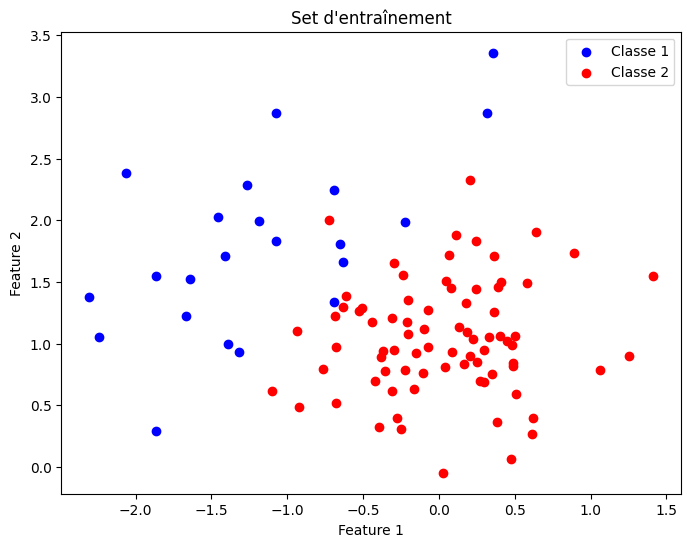

In [17]:
# Affichage du set d'entraînement
plt.figure(figsize=(8, 6))
plt.scatter(x_train[class_train_1, 0], x_train[class_train_1, 1], c='b', label='Classe 1')
plt.scatter(x_train[class_train_2, 0], x_train[class_train_2, 1], c='r', label='Classe 2')
plt.title('Set d\'entraînement')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.savefig("img/premiere-visualisation-set-entrainement.png")
plt.show()

Pour ce qui est du set d'entrainement, on peut apercevoir tous les points des classes 1 et 2 et on peut identifier à l'oeil deux clusters qui sont nos deux classes 1 et 2. 

On peut aussi voir que nous avons plus de points dans la classe 2 que dans la classe 1.

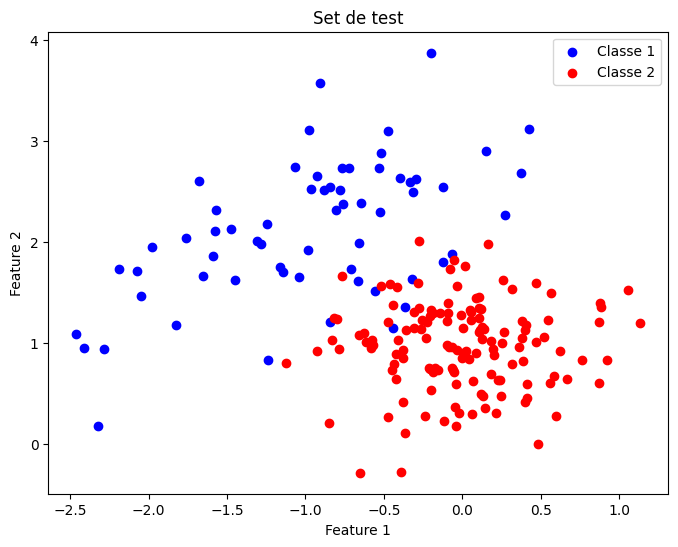

In [18]:
# Affichage du set de test
plt.figure(figsize=(8, 6))
plt.scatter(x_test[class_test_1, 0], x_test[class_test_1, 1], c='b', label='Classe 1')
plt.scatter(x_test[class_test_2, 0], x_test[class_test_2, 1], c='r', label='Classe 2')
plt.title('Set de test')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.savefig("img/premiere-visualisation-set-test.png")
plt.show()

On observe la même chose pour notre set de test. On voit aussi que pour nos deux set on a une répartition légèrement déséquilibrée entre les deux classes (notamment plus de classe 2 que de classe 1 dans notre training set). Nous pouvons donc commencer à faire un preprocessing des données pour réaliser une régression logistique.

### Preparing features for logistic regression (binary classification)
First, we prepare the feature matrix and the target vector associated to 
the training and test sets:


In [19]:
X = np.hstack((np.ones((N_train,1)),x_train))
t = 2-class_train   # 0 if class=2, 1 if class=1

X_test = np.hstack((np.ones((N_test,1)),x_test))
t_test = 2-class_test   # 0 if class=2, 1 if class=1

### Exercise 1 : the logistic function of decision

1. Use the function `regression_logistique.m` to estimate the logistic
regression vector `w`. *Indication : use `Nitermax = 50;
eps_conv=1e-3;`.*
2. Compute the decision function $f(x) = argmax_k P(C_k|x)$ on the test set
to get the classification results. Recall that $y_n=\sigma(w^T x)$ (logistic function)
and that *using vectors* you may directly write $y=\sigma(Xw)$, with the
column of ones in X.
3. Display the results by plotting the points from both the training set
and the test set.
4. Write the equation which defines the decision boundary.
5. Artificially add a few points to the training set far from the decision boundary to check the robustness of logistic regression to outliers. Check the behaviour of LDA for comparison in this case and comment. 


#### Question 1

In [20]:
Nitermax = 50
w, Niter = regression_logistique(X, t, Nitermax) # eps_conv=1e-3 par defaut

print("Estimated logistic regression vector w:")
print(w)
print(f"w was found in {Niter} iterations")

Estimated logistic regression vector w:
[-15.206658    -7.91866363   6.56243114]
w was found in 9 iterations


Le modèle de régression logistique a donc été estimé avec les coefficients suivants :

- $w_0 = -15.206658$
- $w_1 = -7.91866363$
- $w_2 = 6.56243114$

Ces coefficients définissent une frontière de décision linéaire qui sépare les deux classes dans l'espace des caractéristiques. Plus précisément, la frontière de décision est définie par l'équation :

$ -15.206658 - 7.91866363 \cdot x_1 + 6.56243114 \cdot x_2 = 0 $


#### Question 2

In [21]:
def sigma(a): return 1/(1+np.exp(-a)) # sigmoid function

# On définit une classe pour la LogisticRegression afin de compute the decision function
class LogisticRegression():
    
    # On définit nos paramètres
    def __init__(self, train_data, train_target, threshold = 0.5, Nitermax = 50, eps_conv = 1e-3):
        self.train_data = train_data
        self.train_target = train_target
        self.threshold = threshold
        self.Nitermax = Nitermax
        self.eps_conv = eps_conv
        self.coefs, self.Niter = self.__get_coeffs()

    # Méthode pour avoir nos coeffs  
    def __get_coeffs(self):
        return regression_logistique(self.train_data, self.train_target, self.Nitermax, self.eps_conv)
    
    # Méthode de prédiction
    def predict(self, test_data):
        pred = sigma(test_data.dot(self.coefs))
        return np.where(pred >= self.threshold, 1, 0)

In [22]:
# On définit notre object de Logistic regression avec les valeurs de la Q1
logReg = LogisticRegression(X, t)
# On fait la prediction sur notre test set
logReg.predict(X_test)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1,
       0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0,
       0, 1])

#### Question 3

In [23]:
# Import de librairies utiles pour affichage
import sklearn as skl
import seaborn as sns
from sklearn import metrics

In [24]:
# Definition de la grille pour affichage
x1_bounds=(-2.5, 1.5)
x2_bounds=(-1, 5)
figsize=(20,5)

#### Cas du test set

In [25]:
# Data
test_data = X_test
test_target = t_test

# On fait la prédiction de nos data avec la LogisticRegression
prediction = logReg.predict(test_data)

# Calcul des errors
is_wrong_prediction = np.logical_or(np.logical_and(prediction[:] == 1, test_target[:] == 0), np.logical_and(prediction[:] == 0, test_target[:] == 1))
errors = test_data[is_wrong_prediction, :][:,1:]
error_rate = len(errors) / len(test_data)

Affichage des résultats

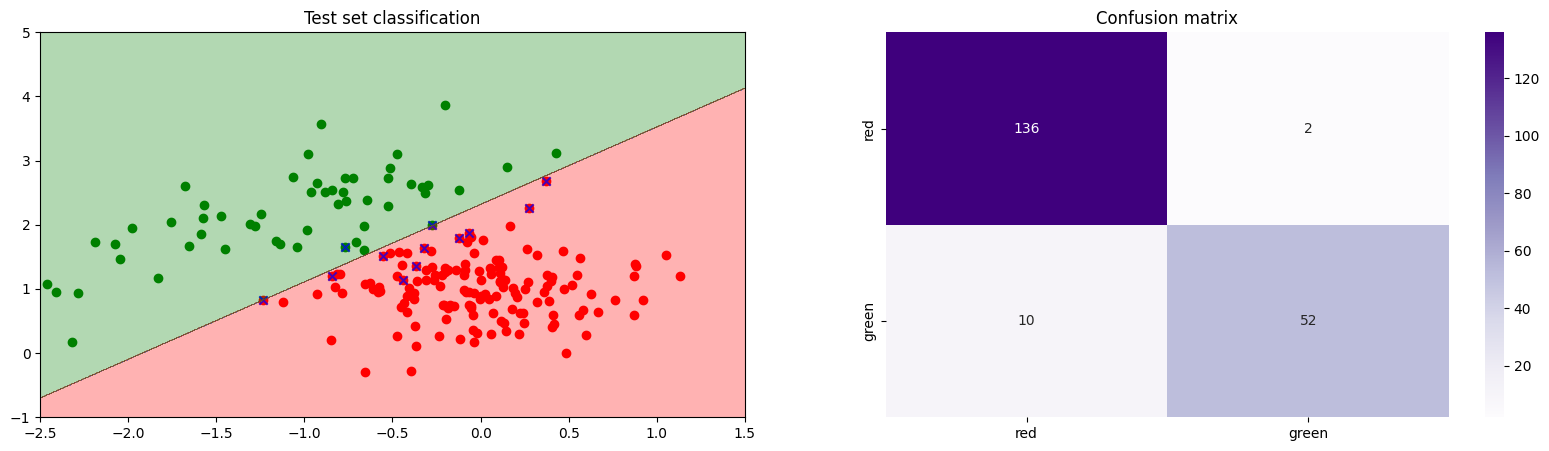

In [26]:
# Resolution
resolution = 1000

# Affichage des resultats pour le test set
plt.figure(figsize=figsize)

# Graphique pour les prédictions et frontière de décision
plt.subplot(121)

# On affiche les prédictions du test set avec des marqueurs bleus pour les prédictions fausses
x_predicted_0 = test_data[prediction[:] == 0, :][:,1:]
x_predicted_1 = test_data[prediction[:] == 1, :][:,1:]

plt.scatter(x_predicted_0[:,0], x_predicted_0[:,1], c='r')
plt.scatter(x_predicted_1[:,0], x_predicted_1[:,1], c='g')
plt.scatter(errors[:,0], errors[:,1], c='b', marker = 'x')
plt.title("Test set classification")

# On affiche des régions de décisions et de la frontière de décision
x1 = np.linspace(x1_bounds[0], x1_bounds[1], resolution) 
x2 = np.linspace(x2_bounds[0], x2_bounds[1], resolution) 
X1, X2 = meshgrid(x1,x2)

X = np.stack((np.ones(resolution**2), np.ravel(X1), np.ravel(X2))).T
Z = logReg.predict(X).reshape(X1.shape)

plt.contourf(X1, X2, Z, colors=['r', 'g', 'b', "y", 'purple'], alpha = 0.3)

# On peut afficher la matrice de confusion
confusion_matrix = skl.metrics.confusion_matrix(test_target, prediction)
plt.subplot(122)
plt.title("Confusion matrix")
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap=plt.cm.Purples, xticklabels=['red', 'green'], yticklabels=['red', 'green'])   

plt.savefig("img/classification-result-logistic-regression-test-set.png")

Notre classification est plutôt bonne, on peut le voir sur le graphique de gauche avec notre frontière de décision. Nous avons tout de même quelques erreurs et plus précisément avec la confusion matrix nous pouvons voir que nous avons 10 points de la classe verte (classe 1) qui ont été mal classifiés en classe rouge (classe 2) et 2 points de la classe rouge (classe 2) qui ont été mal classifiés en classe verte (classe 1)

#### Cas du train set

In [27]:
X = np.hstack((np.ones((N_train,1)),x_train))
t = 2-class_train   # 0 if class=2, 1 if class=1

In [28]:
# Data
test_data = X
test_target = t

# On fait la prédiction de nos data avec la regression logistique
prediction = logReg.predict(test_data)

# Calcul des erreurs
is_wrong_prediction = np.logical_or(np.logical_and(prediction[:] == 1, test_target[:] == 0), np.logical_and(prediction[:] == 0, test_target[:] == 1))
errors = test_data[is_wrong_prediction, :][:,1:]
error_rate = len(errors) / len(test_data)

Affichage des résultats

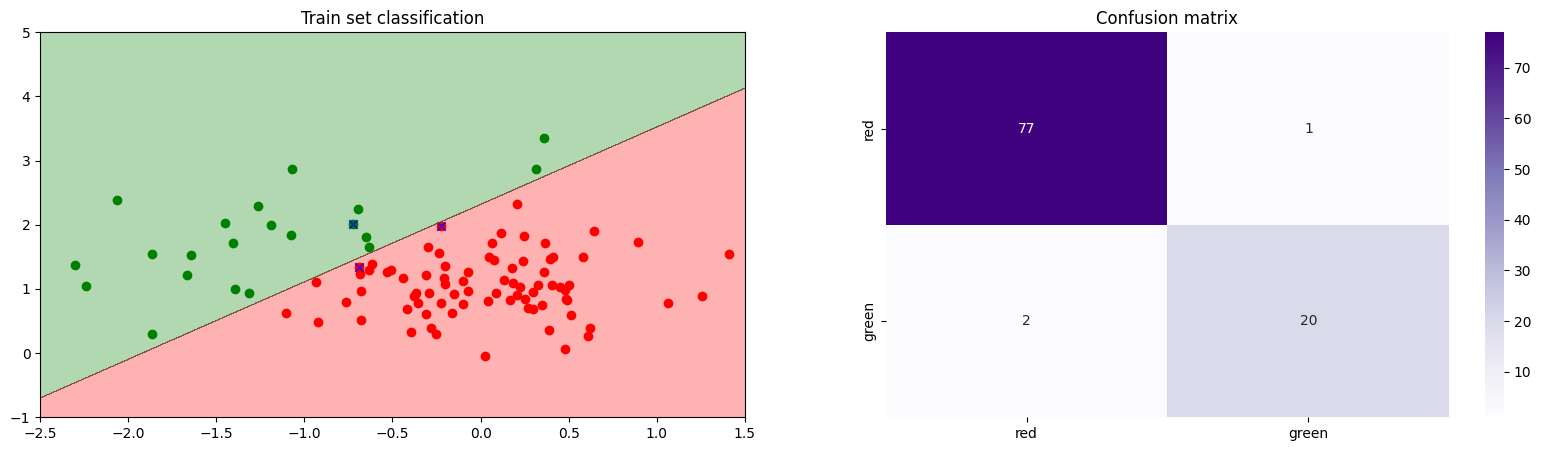

In [29]:
# Resolution
resolution = 1000

# Affichage des resultats pour le test set
plt.figure(figsize=figsize)

# Graphique pour les prédictions et frontière de décision
plt.subplot(121)

# On affiche les prédictions du test set avec des marqueurs bleus pour les prédictions fausses
x_predicted_0 = test_data[prediction[:] == 0, :][:,1:]
x_predicted_1 = test_data[prediction[:] == 1, :][:,1:]

plt.scatter(x_predicted_0[:,0], x_predicted_0[:,1], c='r')
plt.scatter(x_predicted_1[:,0], x_predicted_1[:,1], c='g')
plt.scatter(errors[:,0], errors[:,1], c='b', marker = 'x')
plt.title("Train set classification")

# On affiche des régions de décisions et de la frontière de décision
x1 = np.linspace(x1_bounds[0], x1_bounds[1], resolution) 
x2 = np.linspace(x2_bounds[0], x2_bounds[1], resolution) 
X1, X2 = meshgrid(x1,x2)

X = np.stack((np.ones(resolution**2), np.ravel(X1), np.ravel(X2))).T
Z = logReg.predict(X).reshape(X1.shape)

plt.contourf(X1, X2, Z, colors=['r', 'g', 'b', "y", 'purple'], alpha = 0.3)

# On peut afficher la matrice de confusion
confusion_matrix = skl.metrics.confusion_matrix(test_target, prediction)
plt.subplot(122)
plt.title("Confusion matrix")
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap=plt.cm.Purples, xticklabels=['red', 'green'], yticklabels=['red', 'green'])   

plt.savefig("img/classification-result-logistic-regression-train-set.png")

Notre classification est logiquement meilleure pour notre train set avec un nombre d'erreur de classification moins grand. Ceci s'explique par le fait que notre modèle est entrainé avec nos données d'apprentissage, il est par conséquent logique qu'il soit meilleurs sur ces mêmes données que sur des nouvelles données qu'il ne connait pas.

On observe aussi la même chose que sur le test set : nous avons plus d'erreurs de classification sur la classe verte (classe 1). Cela peut venir du déséqulibre du train set qui a moins de points dans la classe 1.

#### Question 4

La frontière de décision correspond aux couples $(x_1, x_2)$ tels que $\sigma(w^T x) = 0.5$. En d'autres termes :  $w_0 + w_1 x_1 + w_2 x_2 = 0 $.

Comme vu précédemment, le modèle de régression logistique a été estimé avec les coefficients suivants :

- $w_0 = -15.206658$
- $w_1 = -7.91866363$
- $w_2 = 6.56243114$

Ces coefficients définissent une frontière de décision linéaire qui sépare les deux classes dans l'espace des caractéristiques. Plus précisément, la frontière de décision est définie par l'équation :

$ -15.206658 - 7.91866363 \cdot x_1 + 6.56243114 \cdot x_2 = 0 $


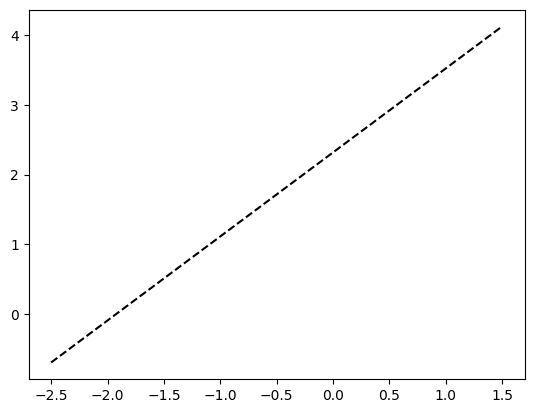

In [30]:
x1 = np.linspace(-2.5,1.5,10) 
x2 = (-w[0]-w[1]*x1)/w[2]
plt.plot(x1,x2,'k--')

Voici à quoi ressemble la frontière de décision 

#### Question 5

In [31]:
X = np.hstack((np.ones((N_train,1)),x_train))
t = 2-class_train   # 0 if class=2, 1 if class=1

In [32]:
nb_points = 10
# on génère 10 points de type outliers
outliers = np.stack([np.ones(nb_points), np.linspace(3,4,nb_points), np.linspace(-1,0,nb_points)]).T

# On les ajoute à nos données (en tant que classe 0)
X_outliers = np.vstack([X, outliers])
t_outliers = np.hstack([t, np.zeros(nb_points)])

### Modèle LDA avec outliers

In [33]:
# Import
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [34]:
# Training the LDA model
lda = LinearDiscriminantAnalysis()
lda.fit(X_outliers, t_outliers)

LinearDiscriminantAnalysis()

### Modèle Logistic Regression avec outliers

In [35]:
logReg_outliers = LogisticRegression(X_outliers, t_outliers)

### On va maintenant afficher nos résultats pour LDA et LogisticRegression

In [36]:
# Definition de la grille pour affichage
x1_bounds = (-2.5, 4.5)
x2_bounds=(-1, 5)

#### LogisticRegression

In [37]:
X_test = np.hstack((np.ones((N_test,1)),x_test))
t_test = 2-class_test   # 0 if class=2, 1 if class=1

In [38]:
# Data
test_data = X_test
test_target = t_test

# On fait la prédiction de nos data avec la regression logistique
prediction = logReg_outliers.predict(test_data)

# Calcul des erreurs
is_wrong_prediction = np.logical_or(np.logical_and(prediction[:] == 1, test_target[:] == 0), np.logical_and(prediction[:] == 0, test_target[:] == 1))
errors = test_data[is_wrong_prediction, :][:,1:]
error_rate = len(errors) / len(test_data)

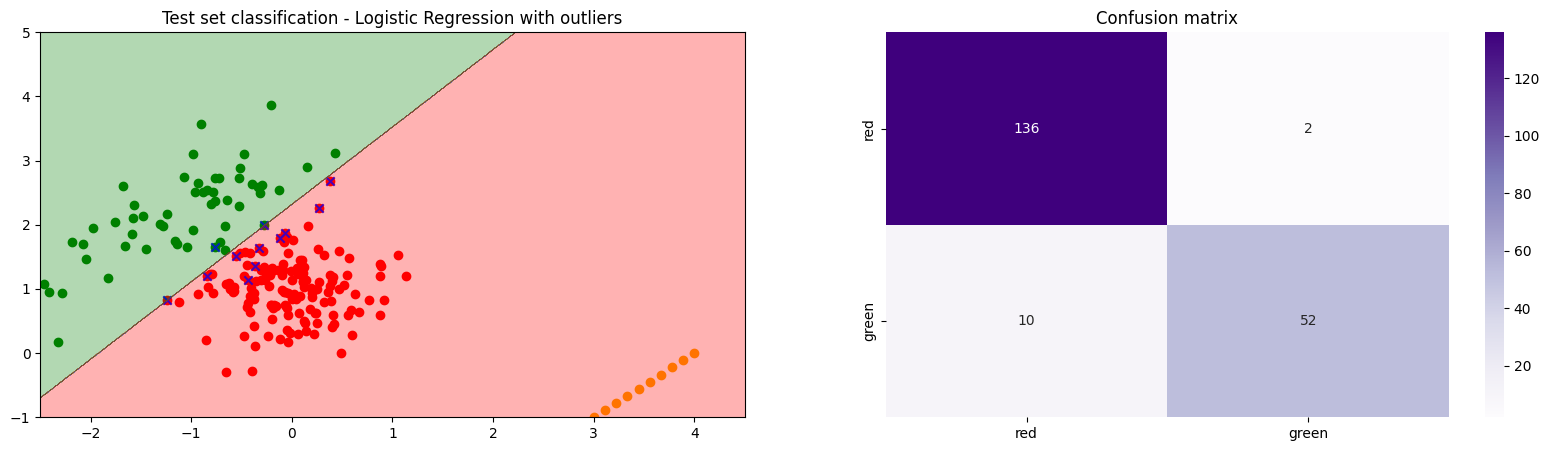

In [39]:
# Resolution
resolution = 1000

# Affichage des resultats pour le test set
plt.figure(figsize=figsize)

# Graphique pour les prédictions et frontière de décision
plt.subplot(121)
plt.scatter(outliers[:,1], outliers[:,2], c='orange')

# On affiche les prédictions du test set avec des marqueurs bleus pour les prédictions fausses
x_predicted_0 = test_data[prediction[:] == 0, :][:,1:]
x_predicted_1 = test_data[prediction[:] == 1, :][:,1:]

plt.scatter(x_predicted_0[:,0], x_predicted_0[:,1], c='r')
plt.scatter(x_predicted_1[:,0], x_predicted_1[:,1], c='g')
plt.scatter(errors[:,0], errors[:,1], c='b', marker = 'x')
plt.title("Test set classification - Logistic Regression with outliers")

# On affiche des régions de décisions et de la frontière de décision
x1 = np.linspace(x1_bounds[0], x1_bounds[1], resolution) 
x2 = np.linspace(x2_bounds[0], x2_bounds[1], resolution) 
X1, X2 = meshgrid(x1,x2)

X = np.stack((np.ones(resolution**2), np.ravel(X1), np.ravel(X2))).T
Z = logReg_outliers.predict(X).reshape(X1.shape)

plt.contourf(X1, X2, Z, colors=['r', 'g', 'b', "y", 'purple'], alpha = 0.3)

# On peut afficher la matrice de confusion
confusion_matrix = skl.metrics.confusion_matrix(test_target, prediction)
plt.subplot(122)
plt.title("Confusion matrix")
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap=plt.cm.Purples, xticklabels=['red', 'green'], yticklabels=['red', 'green'])   

plt.savefig("img/classification-result-logistic-regression-test-set-with-outliers.png")

#### LDA

In [40]:
X_test = np.hstack((np.ones((N_test,1)),x_test))
t_test = 2-class_test   # 0 if class=2, 1 if class=1

In [41]:
# Data
test_data = X_test
test_target = t_test

# On fait la prédiction de nos data avec la regression logistique
prediction = lda.predict(test_data)

# Calcul des erreurs
is_wrong_prediction = np.logical_or(np.logical_and(prediction[:] == 1, test_target[:] == 0), np.logical_and(prediction[:] == 0, test_target[:] == 1))
errors = test_data[is_wrong_prediction, :][:,1:]
error_rate = len(errors) / len(test_data)

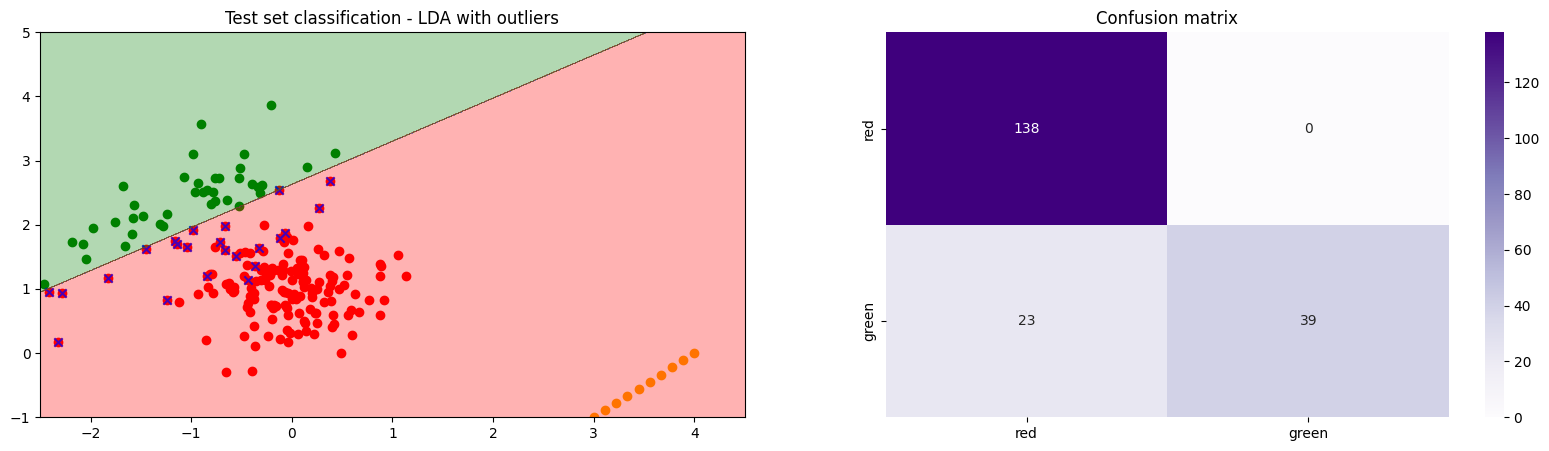

In [42]:
# Resolution
resolution = 1000

# Affichage des resultats pour le test set
plt.figure(figsize=figsize)

# Graphique pour les prédictions et frontière de décision
plt.subplot(121)
plt.scatter(outliers[:,1], outliers[:,2], c='orange')

# On affiche les prédictions du test set avec des marqueurs bleus pour les prédictions fausses
x_predicted_0 = test_data[prediction[:] == 0, :][:,1:]
x_predicted_1 = test_data[prediction[:] == 1, :][:,1:]

plt.scatter(x_predicted_0[:,0], x_predicted_0[:,1], c='r')
plt.scatter(x_predicted_1[:,0], x_predicted_1[:,1], c='g')
plt.scatter(errors[:,0], errors[:,1], c='b', marker = 'x')
plt.title("Test set classification - LDA with outliers")

# On affiche des régions de décisions et de la frontière de décision
x1 = np.linspace(x1_bounds[0], x1_bounds[1], resolution) 
x2 = np.linspace(x2_bounds[0], x2_bounds[1], resolution) 
X1, X2 = meshgrid(x1,x2)

X = np.stack((np.ones(resolution**2), np.ravel(X1), np.ravel(X2))).T
Z = lda.predict(X).reshape(X1.shape)

plt.contourf(X1, X2, Z, colors=['r', 'g', 'b', "y", 'purple'], alpha = 0.3)

# On peut afficher la matrice de confusion
confusion_matrix = skl.metrics.confusion_matrix(test_target, prediction)
plt.subplot(122)
plt.title("Confusion matrix")
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap=plt.cm.Purples, xticklabels=['red', 'green'], yticklabels=['red', 'green'])   

plt.savefig("img/classification-result-lda-test-set-with-outliers.png")

On peut constater que LDA est beaucoup plus sensible aux outliers que la régression logistique : la frontière de décision à tendance à pencher vers ces outliers pour la LDA, provoquant de nombreuses erreurs sur les points verts (classe 1). 

De plus, le taux d'erreur ne change pas pour la régression logistique lorsqu'on ajoute les outliers : cela démontre la robustesse de cette méthode par rapport LDA.

BONUS

On a tout de même plusieurs méthodes pour améliorer notre modèle de LogisticRegression :

- Tout d'abord, on a vu que notre train set était déséquilibré entre les classes 1 et 2. On peut donc faire du sous-échantillonage de le classe majoritaire (classe 2). C'est à dire que nous allons supprimer aléatoirement des exemples de le classe majoritaire. Nous pouvons aussi faire du sur-échantillonnage de la classe minoritaire (classe 1). C'est à dire dupliquer ou générer de nouveaux exemples pour la classe minoritaire afin d'augmenter sa représentation. On pourrait par exemple utiliser la méthode SMOTE qui permet l'oversampling, cette méthode génère des exemples synthétiques de la classe minoritaire.

- Ensuite, nous pouvons aussi utiliser la cross-validation afin d'estimer le taux d'erreur et de trouver le seuil optimal. Actuellement nous avons un seuil de 0.5 mais nous pouvons par exemple utiliser la CV pour tester des valeurs de seuils entre 0.4 et 0.6.

## 2. Application: handwritten digits recognition 5 & 6
We load 2 matrices which contain each a sequence of examples of 16x16 images 
of handwritten digits which are 5 and 6 here. Each line of the matrix
contains 256 pixel values coding for the gray level of a 16x16 image.

In [43]:
train_5 = np.loadtxt('train_5.txt',delimiter=',')   # 556 samples
train_6 = np.loadtxt('train_6.txt',delimiter=',')   # 664 samples

### Examples of images


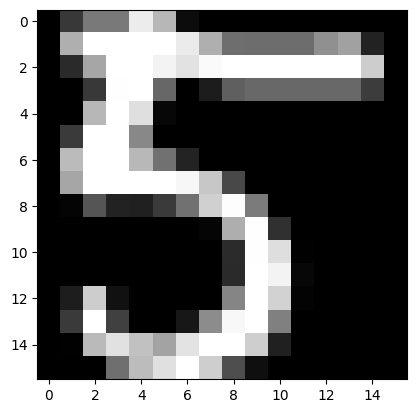

In [44]:
# Digit 5
n=9
I = np.reshape(train_5[n,:],(16,16))

plt.imshow(I,cmap='gray')
plt.show()

In [45]:
# Digit 6
n=5
I = reshape(train_6[n,:],(16,16))

plt.imshow(I,cmap='gray')
plt.show()

NameError: name 'reshape' is not defined

### Separating the training and test sets

We keep in the training set the 145 first images of 5s and the 200 first
images of 6s:


In [ ]:
x_train_brut = np.vstack((train_5[:145,:], train_6[:200,:]))
N_train = np.size(x_train_brut,axis=0)
class_train = np.ones((345,))   # label 1 for digit 6
class_train[:145] = 0       # label 0 for digit 5

x_test_brut = np.vstack((train_5[145:,:], train_6[200:,:]))
N_test = np.size(train_5,axis=0)+np.size(train_6,axis=0)-N_train

## Exercise 2: logistic regression to classify 5 & 6

1. Note that pixel values are between -1 and 1 by using the functions
 `min(I(:))` and `max(I(:))`.
2. Identify the indices of the most significant pixels, which are defined 
as having a standard deviation greater than 0.5 here. We denote by `lis_sig`
the list of positions of these significant pixels in the image vector.
_Indication : the function `std` gives the standard deviation (columnwise
in matrices) and you should find 173 pixel positions.
3. Show a binary image to locate these pixels.
_Indication : `Isig = zeros(16); Isig(list_sig)=1; Isig=Isig';`._
4. Define the training set `x_train` from `x_train_brut` from the significant pixels only.
5. Do the same with `x_test_brut` to extract `x_test`.
6. Use `regression_logistique.m` to estimate the logistic regression vector
`w` from the training set `x_train`. 
Choose `Nitermax = 13; eps_conv = 1e-3;`
7. Compute the decision function and the labels of the test set `x_test`. 
_Indication : do not forget the column of ones !_
8. Estimate the classification error rate by using :
`erreur = sum(abs(class-class_test))/N_test;`.
9. Locate some misclassified examples and visualize the corresponding image.
Comment on your results and observations.


#### Question 1

In [ ]:
print(f"The minimum pixel values is {np.min(I[:])}")
print(f"The maximum pixel values is {np.max(I[:])}.")

On observe bien que nos valeurs de pixel sont comprises entre -1 et 1

#### Question 2

In [ ]:
# Std pour tous les points du dataset
std = np.std(x_train_brut, axis=0)
I_std_heat = std.reshape((16,16))

# On peut maintenant connaitre les pixels les plus importants (std > 0.5)
std_bin = np.array([std>0.5])[0]
I_std_bin = std_bin.reshape((16,16))

#### Question 3

In [ ]:
# Affichage Std pour tous les points d'une image
plt.figure(figsize=(13,4.6))
plt.subplot(121)
plt.title("Standard deviation for each pixel over the entire dataset")
sns.heatmap(I_std_heat)

# Affichage des pixels les plus importants (std > 0.5)
plt.subplot(122)
plt.title(f"Display of the {sum(std_bin)} most important pixels (std>0.5)")
sns.heatmap(I_std_bin)

plt.savefig("img/display-most-important-pixel-datatset.png")

On observe que les pixels ayant l'écart type le plus élevé sont situés de manière à pouvoir insérer des 5 et des 6 dans la "silhouette" produite par la carte thermique. Par exemple, on reconnaît la forme ronde commune aux 5 et aux 6 en bas de l'image. 

Cela traduit bien le fait que ces pixels sont ceux qu'il est important d'observer lorsqu'il s'agit d'identifier les deux chiffres.

Etant donné qu'on observe un peu plus le "6" que le "5" sur le graphique au dessus, nous pouvons afficher les pixels les plus significatifs pour les 5.  

In [ ]:
std_5 = np.std(train_5, axis=0)

plt.figure(figsize=(10,10))
plt.title("Standard deviation for each pixel in the 5's dataset")
sns.heatmap(std_5.reshape((16,16)))

plt.savefig("img/display-most-important-pixel-5.png")

Cette fois ci on observe bien mieux les pixels importants pour reconnaitre naturellement le chiffre 5

#### Question 4

In [ ]:
x_train = x_train_brut[:, std_bin]

print(f"Le nombre de colonne de x_train est réduit à {x_train.shape[1]}.")

On réduit donc bien notre train set aux 173 pixels les plus significatifs

#### Question 5

In [ ]:
x_test = x_test_brut[:, std_bin]

print(f"Le nombre de colonne de x_test est réduit à {x_test.shape[1]}.")

De même, on réduit bien notre test set aux 173 pixels les plus significatifs

#### Question 6

In [ ]:
# Paramètres 
Nitermax = 13
eps_conv = 1e-3

# On ajoute la colonne de 1
x_train_t = np.hstack((np.ones((N_train,1)),x_train))

logReg_exo2 = LogisticRegression(x_train_t, class_train, Nitermax = Nitermax, eps_conv = eps_conv)

# On peut maintenant obtenir les coefficients
w = logReg_exo2.coefs

print(f"w est donc de taille {w.shape} (coeffs pour 173 pixels les plus importants et 1 pour le biais)")

#### Question 7

In [ ]:
# On ajoute la colonne de 1
x_test_t = np.hstack((np.ones((N_test,1)),x_test))

prediction = logReg_exo2.predict(x_test_t)

Nous avons désormais toutes les prédictions de notre modèle de LogisticRegression sur notre test set.

#### Question 8

In [ ]:
error = sum(abs(prediction-class_test))/N_test
print(f"L'estimation du taux d'erreur pour notre modèle est : {error*100}%.")

On peut aussi montrer la confusion matrix pour comprendre quelles erreurs sont faites par notre modèle :

In [ ]:
confusion_matrix = skl.metrics.confusion_matrix(class_test, prediction)
plt.title("Confusion matrix")
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap=plt.cm.Purples, xticklabels=['5', '6'], yticklabels=['5', '6']) 
plt.savefig("img/confusion-matrix-lr-exo2.png")  

On observe donc que notre modèle fait 70 erreurs de prédictions :

* 45 5 ont été étiquetés comme 6, ce qui représente un taux d'erreur de 45/410 ≈ 11 %
* 25 6 ont été étiquetés comme 5, ce qui représente un taux d'erreur de 25/465 ≈ 5.4 %

Cela signifie que, proportionnellement, plus d'erreurs ont été faites sur les 5. 

Ce résultat peut provenir du fait qu'il y avait plus de 6 que de 5 dans notre train set. On a donc un modèle qui est capable de reconnaître les 6, mais qui n'a pas été suffisamment entraîné pour reconnaître les 5 : il s'agit d'une forme de surapprentissage

#### Question 9

9. Locate some misclassified examples and visualize the corresponding image.
Comment on your results and observations.

In [ ]:
# On identifie les erreurs
error_mask = abs(prediction-class_test)
error_mask = error_mask.astype(int)
mistakes = x_test_brut[error_mask==1]

# Fonction pour afficher l'image
def display_image(data, index):
    img = reshape(data[index,:],(16,16))
    plt.imshow(img,cmap='gray')

In [ ]:
# Nombre d'erreurs qu'on veut afficher ; ici on a choisi 9
nb_to_display = 9 

offset = 0 

plt.figure(figsize=(15,5))

for i in range(1, nb_to_display+1):
    plt.subplot(100 + nb_to_display*10 + i)
    display_image(mistakes, offset + i) # images mal identifiés comme 5
plt.savefig("img/erreur-prediction-classe-5.png")
    
    
plt.figure(figsize=(15,5))
for i in range(1, nb_to_display+1):
    plt.subplot(100 + nb_to_display*10 + i)
    display_image(mistakes, -offset - i) # images mal identifiées comme 6
plt.savefig("img/erreur-prediction-classe-6.png")

En observant les erreurs, on peut comprendre que certains 5 ci-dessus aient été confondus avec des 6. Typiquement, l'image 1 4 et 6 (en partant de la gauche) peuvent ressembler à des 6.

En ce qui concerne les 6 qui ont été confondus avec des 5, la prédiction semble un peu moins logique car on peut assez facilement reconnaitre des 6 pour certains. Une des explications peut être que certains 6 subissent une légère rotation.

## 3. Logistic regression using `scikit-learn`

1. **Go to** http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html for a presentation of the logistic regression model in `scikit-learn`.

2. **Apply** it to the present data set.

3. **Comment** on the use of logistic regression.

*Indication : you may have a look at* 

a) Theory : http://openclassroom.stanford.edu/MainFolder/DocumentPage.php?course=MachineLearning&doc=exercises/ex5/ex5.html

b) Video :  https://kr.coursera.org/lecture/machine-learning/regularized-logistic-regression-cAxpF 

c) Example : http://scikit-learn.org/stable/auto_examples/exercises/plot_digits_classification_exercise.html#sphx-glr-auto-examples-exercises-plot-digits-classification-exercise-py

*for a short presentation of regularized logistic regression.*

In [ ]:
from sklearn.linear_model import LogisticRegression as SKLLogisticRegression # On renomme pour ne pas confondre avec celle de l'exo 1

# Entrainement du modèle de scikit-learn
sk_learn_lr = SKLLogisticRegression().fit(x_train_t, class_train)

In [ ]:
# Prediction
prediction_sklearn = sk_learn_lr.predict(x_test_t)

Nous avons ici un nouveau modèle de regression logistique ainsi que les prédictions faites par ce modèle pour notre test set

In [ ]:
error_sklearn = sum(abs(prediction_sklearn-class_test))/N_test
print(f"L'estimation du taux d'erreur pour le modèle de sklearn est : {error_sklearn*100}%.")

In [ ]:
confusion_matrix = skl.metrics.confusion_matrix(class_test, prediction_sklearn)
plt.title("Confusion matrix")
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap=plt.cm.Purples, xticklabels=['5', '6'], yticklabels=['5', '6']) 
plt.savefig("img/confusion-matrix-lr-exo2.png")  

Nous observons que sklearn parvient à avoir un meilleur taux d'erreurs que notre implémentation de régression logistique. De plus, il fait moins d'erreurs de prédictions sur les 5.

Ceci s'explique par le fait que sklearn utilise une régression logistique régularisée qui aide à réduire le surappentissage.

On peut regarder ce que donne la régression logistique de sklearn sans pénalité pour nous assurer que la régularisation est bien ce qui améliore les performances.

In [ ]:
sk_learn_lr_no_penalty = SKLLogisticRegression(penalty='none').fit(x_train_t, class_train)
prediction_sklearn_no_penalty = sk_learn_lr_no_penalty.predict(x_test_t)

In [ ]:
error_sklearn_no_penalty = sum(abs(prediction_sklearn_no_penalty-class_test))/N_test
print(f"With sklearn without the penalty, the estimated error rate for the numbers of prediction is {error_sklearn_no_penalty*100}%.")

In [ ]:
confusion_matrix = skl.metrics.confusion_matrix(class_test, prediction_sklearn_no_penalty)
plt.title("Confusion matrix")
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap=plt.cm.Purples, xticklabels=['5', '6'], yticklabels=['5', '6']) 
plt.savefig("img/confusion-matrix-lr-exo2.png")  

Nous observons que la prédiction de sklearn est moins bonne sans régularisation. Toutefois, elle reste meilleure que la nôtre : cela pourrait être dû au fait que sklearn utilise une forme d'optimisation pour améliorer les prédictions (par exemple une optimisation du seuil)

Toutefois, il semble que la régularisation joue un rôle important dans l'amélioration des performances de la régression logistique.
